In [2]:
import sys
sys.path.append("../../src")

import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

from utils.kernel_utils import Kernel, ColumnwiseRBF, RBF, MaternKernel, ColumnwiseMaternKernel, EpanechnikovKernel, LinearKernel
from causal_models.proxy_causal_learning import KernelAlternativeProxyATE
from utils.ml_utils import data_transform
from generate_experiment_data import generate_synthetic_data, High_dim

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

if not os.path.exists("Figures"):
    os.mkdir("Figures")

gpu


In [3]:
data_size = 1000
train_size = 900
test_size = 100
seed = np.random.randint(1000000)
np.random.seed(seed)

U, W, Z, A, Y, do_A, EY_do_A = generate_synthetic_data(size = data_size, seed = seed, do_A_range = (-1, 2))
W_train, Z_train, A_train, Y_train = W[:train_size], Z[:train_size], A[:train_size], Y[:train_size]
W_test, Z_test, A_test, Y_test = W[train_size: train_size + test_size], Z[train_size: train_size + test_size], A[train_size: train_size + test_size], Y[train_size: train_size + test_size]

A_transformed, A_transformer = data_transform(A_train)
Z_transformed, Z_transformer = data_transform(Z_train)
W_transformed, W_transformer = data_transform(W_train)
Y_transformed, Y_transformer = data_transform(Y_train)

A_test_transformed = jnp.array(A_transformer.transform(A_test).reshape(test_size, -1))
Z_test_transformed = jnp.array(Z_transformer.transform(Z_test).reshape(test_size, -1))
W_test_transformed = jnp.array(W_transformer.transform(W_test).reshape(test_size, -1))
Y_test_transformed = jnp.array(Y_transformer.transform(Y_test).reshape(test_size, -1))

A_transformed = jnp.array(A_transformed).reshape(train_size, -1)
Z_transformed = jnp.array(Z_transformed).reshape(train_size, -1)
W_transformed = jnp.array(W_transformed).reshape(train_size, -1)
Y_transformed = jnp.array(Y_transformed).reshape(train_size, -1)

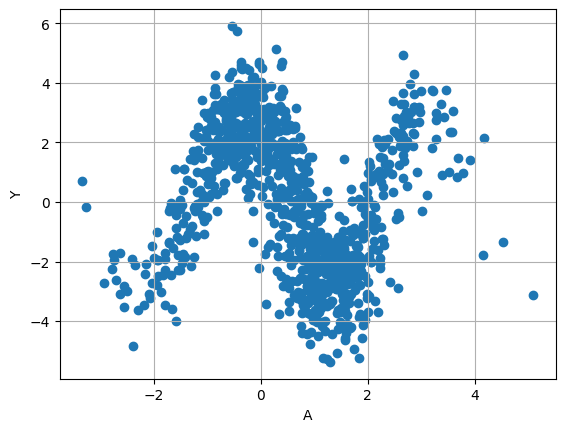

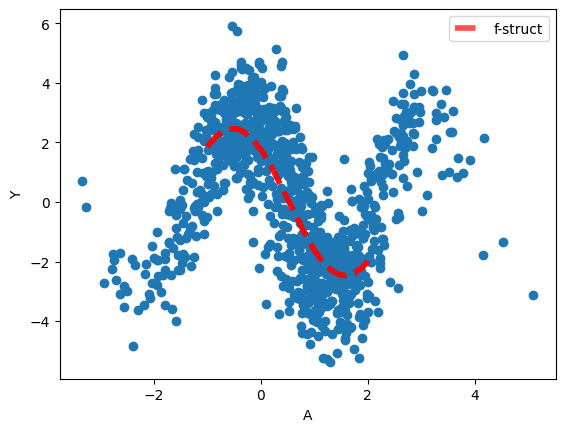

In [4]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.savefig('Figures/AltenativeProxySyntheticDataScatter.pdf', format='pdf')
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.savefig('Figures/AltenativeProxySyntheticDataTreatmentEffect.pdf', format='pdf')
plt.legend()

plt.scatter(A, Y)
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()

# Hyperparameters for the Model

In [5]:
seed = np.random.randint(1000000)
np.random.seed(seed)

RBF_Kernel_Z = RBF(use_length_scale_heuristic = True)
RBF_Kernel_W = ColumnwiseRBF(use_length_scale_heuristic = True)
RBF_Kernel_A = RBF(use_length_scale_heuristic = True)

lambda_ = 0.1
eta = 1.2*1e-2
lambda2_ = 0.1
optimize_lambda_parameters = True
optimize_eta_parameter = True
lambda_optimization_range = (1e-7, 1.0)
eta_optimization_range = (1e-7, 1.0)
stage1_perc = 0.5
regularization_grid_points = 150
make_psd_eps = 5e-9

model = KernelAlternativeProxyATE(
                                     kernel_A = RBF_Kernel_A,
                                     kernel_W = RBF_Kernel_W, 
                                     kernel_Z = RBF_Kernel_Z,
                                     lambda_ = lambda_,
                                     eta = eta,
                                     lambda2_ = lambda2_,
                                     optimize_lambda_parameters = optimize_lambda_parameters,
                                     optimize_eta_parameter = optimize_eta_parameter,
                                     lambda_optimization_range = lambda_optimization_range,
                                     eta_optimization_range = eta_optimization_range,
                                     stage1_perc = stage1_perc,
                                     regularization_grid_points = regularization_grid_points, 
                                     make_psd_eps = make_psd_eps,
                                     label_variance_in_lambda_opt = 0.,
                                     label_variance_in_eta_opt = 1.0,
                                  )

# Fit the Model and Make Predictions

Structured function test set MSE: 0.1532141779647117
Structured function test set MAE: 0.3368444328024222


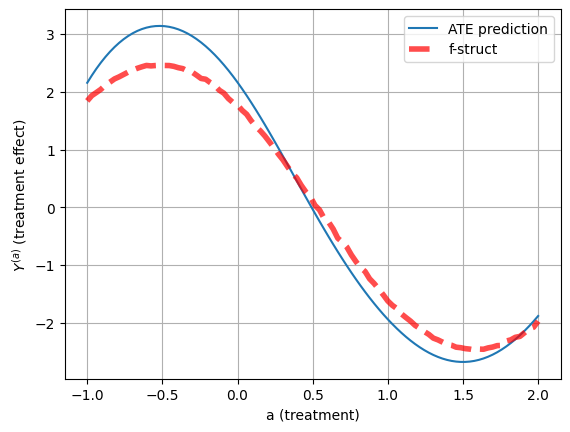

In [6]:
model.fit((A_transformed, W_transformed, Z_transformed), Y_transformed)
do_A_size = do_A.shape[0]
do_A_transformed = (A_transformer.transform(do_A)).reshape(do_A_size, -1)
f_struct_pred_transformed = model.predict(do_A_transformed)
f_struct_pred = Y_transformer.inverse_transform(f_struct_pred_transformed.reshape(do_A_size, -1)).reshape(do_A_size, -1)

structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))
print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))

plt.plot(do_A, f_struct_pred, label = "ATE prediction")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()

In [7]:
model.kernel_A.length_scale, model.kernel_Z.length_scale, model.kernel_W.length_scales

(0.6796400929829041,
 1.2042376628346971,
 [0.6939745906906462, 0.6948894180767494])

Text(0.5, 0.92, 'Treatment Bridge Function Estimation, A = [-1.53728939]')

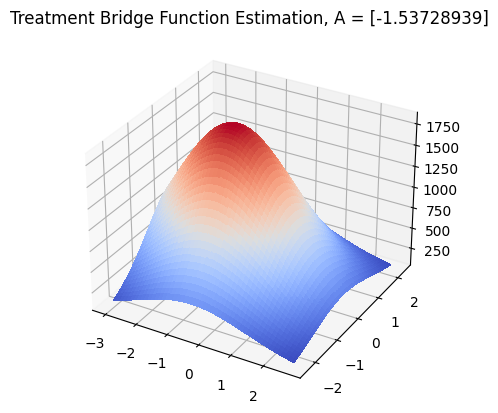

In [8]:
from utils.linalg_utils import make_psd, cartesian_product
from matplotlib import cm

Z_grid1 = jnp.linspace(Z_transformed[:,0].min(), Z_transformed[:,0].max(), 100)
Z_grid2 = jnp.linspace(Z_transformed[:,1].min(), Z_transformed[:,1].max(), 100)
Z_test = cartesian_product(Z_grid1, Z_grid2)

B = model.B
B_bar = model.B_bar
K_ZZTest = model.kernel_Z(model.ZTrain, Z_test)[tuple(cartesian_product(model.stage1_idx, jnp.arange(Z_test.shape[0])).T)].reshape(model.stage1_idx.shape[0], Z_test.shape[0])
K_ATildeA = model.kernel_A(model.ATrain, model.ATrain)[tuple(cartesian_product(model.stage2_idx, model.stage1_idx).T)].reshape(model.stage2_idx.shape[0], model.stage1_idx.shape[0])
treatment_idx = 25
K_Atilde_a = K_ATildeA[:, treatment_idx].reshape(-1, 1)
alpha = model.alpha
alpha_1_m = alpha[0:-1]
alpha_m_plus_1 = alpha[-1]
Z_plot = Z_transformed[model.stage1_idx]
A_plot = A_transformed[model.stage1_idx]
bridge = alpha_1_m.T @ (B.T @ K_ZZTest * K_Atilde_a) + alpha_m_plus_1 * (jnp.ones((model.stage2_idx.shape[0], 1)).T @ (B_bar.T @ K_ZZTest * K_Atilde_a))
bridge = bridge.reshape(Z_grid1.shape[0], Z_grid2.shape[0])

X, Y = np.meshgrid(Z_grid1, Z_grid2)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, bridge, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,)
plt.title("Treatment Bridge Function Estimation, A = {}".format(model.ATrain[model.stage1_idx][treatment_idx]))

0.006901224802908533


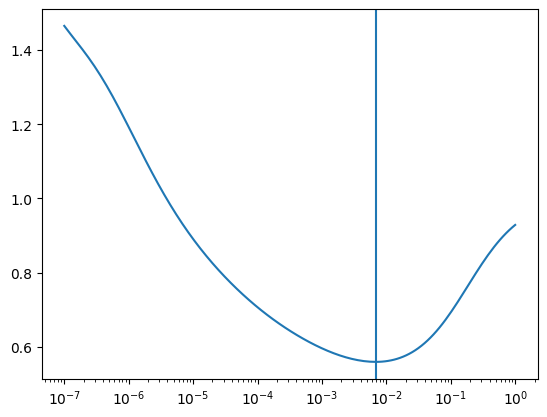

In [9]:
plt.semilogx(model.lambda_list, model.lambda_objective_list)
plt.axvline(model.lambda_)
print(model.lambda_) 

0.0018843769586593107


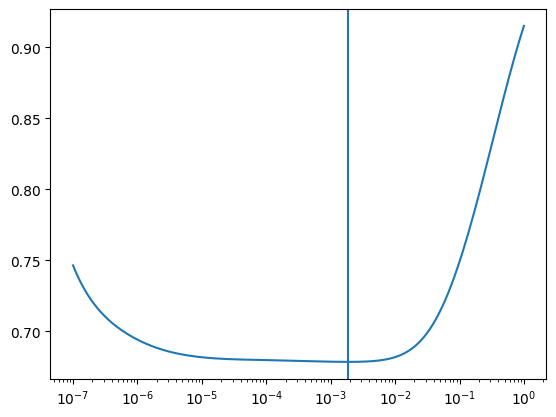

In [10]:
plt.semilogx(model.lambda_list, model.lambda2_objective_list)
plt.axvline(model.lambda2_)
print(model.lambda2_) 

0.0016911725446448075


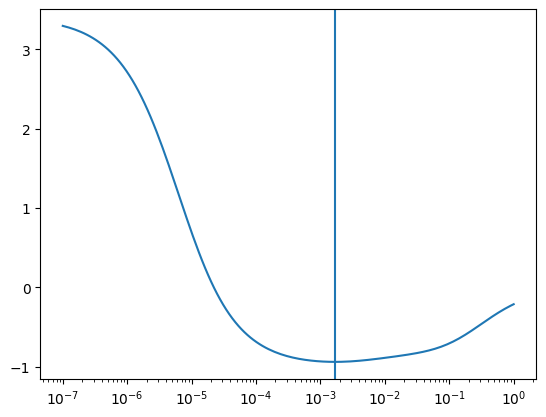

In [11]:
plt.semilogx(model.eta_list, model.eta_objective_list)
plt.axvline(model.eta)
print(model.eta) 

<StemContainer object of 3 artists>

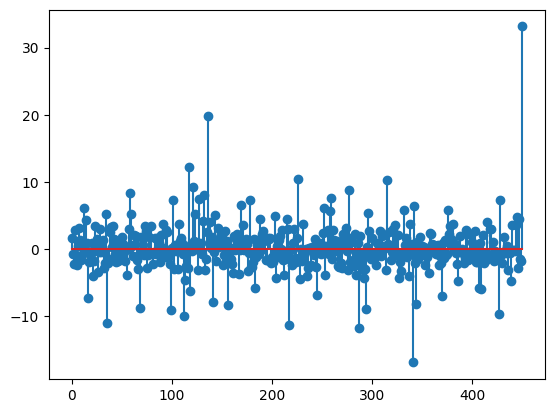

In [12]:
plt.stem(model.alpha)